# Podstawy aproksymacji - od analizy Fouriera do deep learningu
## Projekt zaliczeniowy - sieć konwolucyjna umożliwiająca rozpoznanie wybranych owoców

### Autorzy:
### Zuzanna Danilczuk 102341
### Justyna Jędruszek 85326
### Sylwia Gawrońska 103095


### Opis projektu

Celem projektu jest zaprogramowanie sieci konwolucyjnej zdolnej do rozpoznawania dwóch wybranych owoców: jabłek i bananów. Dataset, który posłużył do zbudowania sieci jest dostępny pod linkiem: https://www.kaggle.com/sriramr/apples-bananas-oranges. Ponieważ dataset składa się z 6 podkategorii (po 2 foldery na owoc), wybrałam 4 sposród nich - dla jabłek i bananów i utworzyłam dataset treningowy i testowy.


#### Pierwszym krokiem jest wgranie niezbędnych bibliotek

In [35]:
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image

#### Następnie zajmiemy się przygotowaniem danych do modelu

In [10]:
trainingfilenames = os.listdir(r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\original_data_set\trainingset\trainingapples")
categories = []
for filename in trainingfilenames:
    categories.append("apples");
    
training2filenames = os.listdir(r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\original_data_set\trainingset\trainingbanana")
categories2 = []
for filename in training2filenames:
    categories2.append("banana");
    
trainingfilenames.extend(training2filenames)
categories.extend(categories2)

train_df = pd.DataFrame({
    'filename': trainingfilenames,
    'category': categories
})
    
    
testingfilenames = os.listdir(r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\original_data_set\testingset\testingbanana")
categories = []
for filename in testingfilenames:
    categories.append("banana");
    
testing2filenames = os.listdir(r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\original_data_set\testingset\testingapples")
categories2 = []
for filename in testing2filenames:
    categories2.append("apples");
    
testingfilenames.extend(testing2filenames)
categories.extend(categories2)

test_df = pd.DataFrame({
    'filename': testingfilenames,
    'category': categories
})

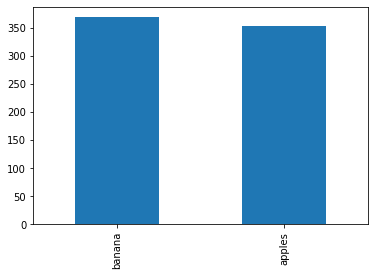

In [13]:
train_df['category'].value_counts().plot.bar() #sprawdzam liczebność danych treningowych

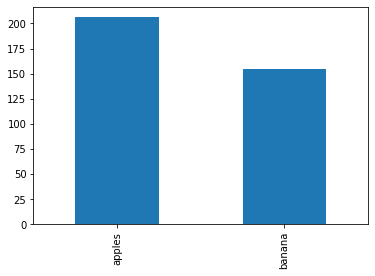

In [14]:
test_df['category'].value_counts().plot.bar() #sprawdzam liczebność danych testowych

#### Poniżej dokonujemy transformacji danych treningowych i testowych, aby zapobiec overfittingowi

In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
training_set = train_datagen.flow_from_directory(
        r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\original_data_set\trainingset",
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 851 images belonging to 2 classes.


In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
        r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\original_data_set\testingset",
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 232 images belonging to 2 classes.


#### Przechodzimy do budowy sieci konwolucyjnej

In [17]:
#definiuję stałe

FAST_RUN = False
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [28]:
#buduję sieć

#wgrywam potrzebne biblioteki
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

#inicjuję sieć
CNN_model = Sequential()

#dodaję warsty, jako funkcję aktywacji użyłam Rectified Linear Units. Funkcja MaxPooling została użyta w celu zmniejszenia próbkowana obrazu, co oznacza, że w naszym modelu obrazy będą sprawdzane co 2 pixele
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(2, activation='softmax'))
#kompiluję sieć
CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
__________

#### Następnie przystępuję do trenowania sieci

In [19]:
#Na początek w celu dodatkowego zabezpieczenia przed zbytnim dopasowaniem sieci użyjemy funkcji EarlyStopping

from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [30]:
earlystop = EarlyStopping(patience=10)

In [31]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [32]:
callbacks = [earlystop, learning_rate_reduction]

In [33]:
#Przystępujemy do trenowania

CNN_model.fit(x = training_set, validation_data = test_set, epochs = 25)

Epoch 1/25
27/27 [==============================] - 34s 1s/step - loss: 0.3209 - acc: 0.9130 - val_loss: 0.5253 - val_acc: 0.7112
Epoch 2/25
27/27 [==============================] - 33s 1s/step - loss: 0.1979 - acc: 0.9424 - val_loss: 0.5357 - val_acc: 0.6767
Epoch 3/25
27/27 [==============================] - 36s 1s/step - loss: 0.1503 - acc: 0.9577 - val_loss: 2.5159 - val_acc: 0.5043
Epoch 4/25
27/27 [==============================] - 38s 1s/step - loss: 0.1939 - acc: 0.9436 - val_loss: 3.5062 - val_acc: 0.5043
Epoch 5/25
27/27 [==============================] - 36s 1s/step - loss: 0.1237 - acc: 0.9553 - val_loss: 0.9348 - val_acc: 0.6724
Epoch 6/25
27/27 [==============================] - 33s 1s/step - loss: 0.1090 - acc: 0.9624 - val_loss: 0.4669 - val_acc: 0.8750
Epoch 7/25
27/27 [==============================] - 33s 1s/step - loss: 0.0981 - acc: 0.9683 - val_loss: 0.7968 - val_acc: 0.7371
Epoch 8/25
27/27 [==============================] - 34s 1s/step - loss: 0.0988 - acc: 0.97

#### Wizualizacja trenowania

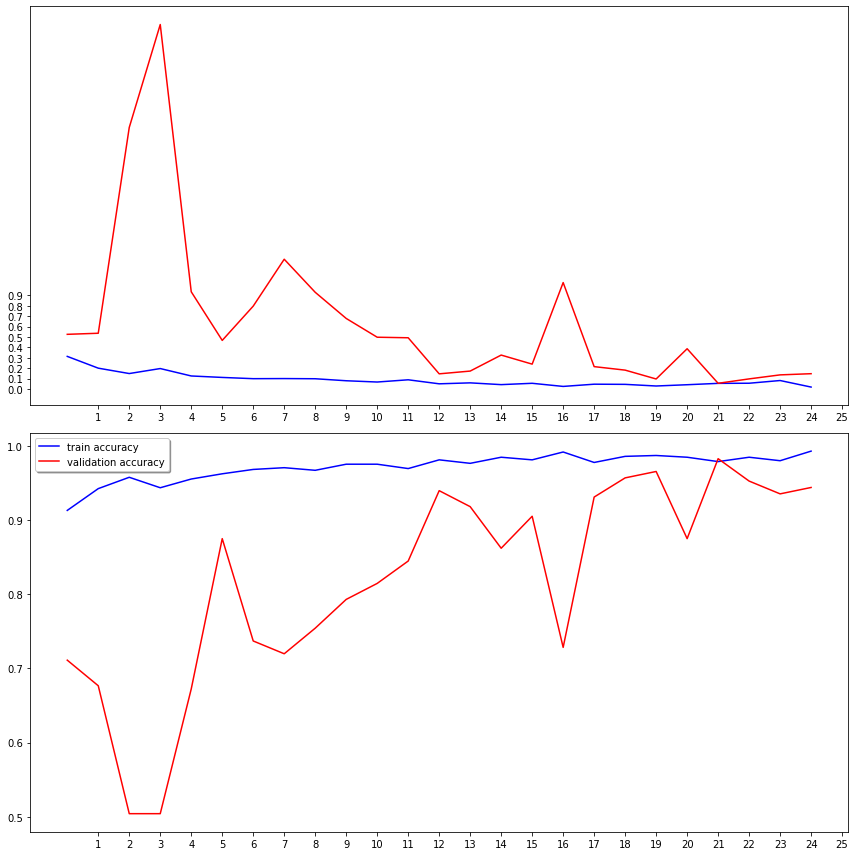

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(CNN_model.history.history['loss'], color='b', label="train loss")
ax1.plot(CNN_model.history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 26, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(CNN_model.history.history['acc'], color='b', label="train accuracy")
ax2.plot(CNN_model.history.history['val_acc'], color='r',label="validation accuracy")
ax2.set_xticks(np.arange(1, 26, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [42]:
test_image = image.load_img(r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\original_data_set\testingset\testingbanana\test1.png", target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = CNN_model.predict(test_image)

training_set.class_indices
if result[0][0]==1:
    prediction = "apple"
else: 
    prediction = "banana"

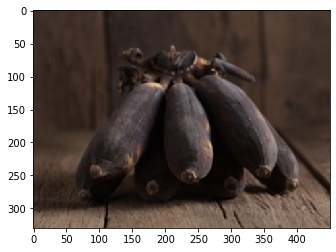

In [43]:
test_image_show = image.load_img(r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\original_data_set\testingset\testingbanana\test1.png")
plt.imshow(test_image_show)

In [44]:
print(prediction)

banana


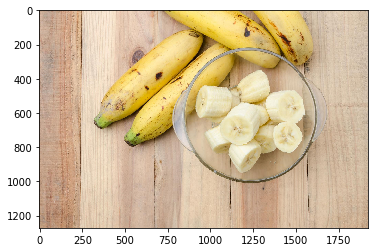

In [49]:
test_image_show = image.load_img(r"C:\Users\zuzanna.danilczuk.PPE.000\Desktop\Projekt\randombanan.jpg")
plt.imshow(test_image_show)

In [50]:
print(prediction)

banana
